$$
\newcommand{\sign}{\mathrm{sign}}
%
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vx}{\mathbf{x}}
$$

# Lecture 1: Introduction
## Pattern Recognition, Fall 2022

**Ivan Dokmanić**

<br><br><br>

<img src="figs/sada-unibas-0.svg" width="60%" float="left">





# What's the plan?

- Pattern recognition is about ... recognizing patterns!
- Normally we would have to start by defining a "pattern", "recognition", and all that...

<center>
<img src="figs/yoda.jpg" width="40%" />
</center>

I'm a big fan of learning by doing, so before getting all historical, philosophical, and mathematical, and asking what is a pattern, let's start by recognizing patterns!


# Yann LeCun and MNIST ftw

<center>
    <img src="figs/lecun-mnist.jpg" width="70%">
</center>

- A very early evangelist of convolutional neural networks, backpropagation, and all that
- One of the poster boys of deep learning
- The creator of the indestructible MNIST dataset



# MNIST

Let's start by loading and displaying a couple of digits

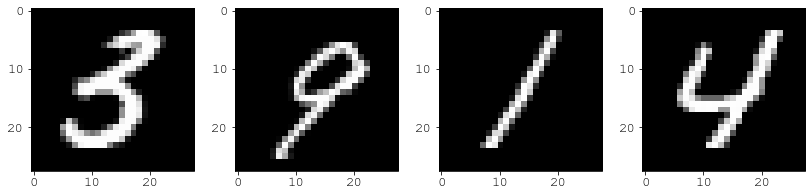

In [33]:
from mlxtend.data import loadlocal_mnist

X_train, y_train = loadlocal_mnist(
        images_path='/Users/dokman0000/Downloads/train-images-idx3-ubyte', 
        labels_path='/Users/dokman0000/Downloads/train-labels-idx1-ubyte'
        )

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(14, 3))
for ax in axs:
    ax.imshow(X_train[np.random.randint(1000)].reshape(28, 28), cmap='gray')

# Our goal: ship a PR system

- We have some examples of patterns and classes from the real world
- We can do whatever we want with them
- But we have no clue what our system will see out there!
- Hope: similar stuff, similar "distribution", but certainly not the same



# Let's focus on two digits

In [12]:
classes = [4, 7]
d = 28**2
X = np.ndarray((0, d))
y = np.ndarray((0, 1))

for cl in classes:
    X = np.vstack((X, X_train[y_train == cl]))
    y = np.vstack((y, y_train[y_train == cl, np.newaxis]))

n = len(y)
shuffle_idx = np.random.permutation(n) - 1
X = X[shuffle_idx]
y = y[shuffle_idx].flatten()
y = 2*(y == classes[0]) - 1

n = 5000
X = X[:n]
y = y[:n]

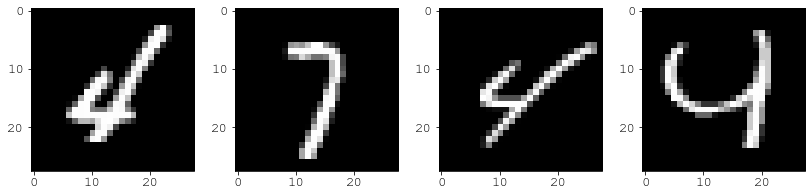

In [13]:
# (some hidden code above selects only 4s and 7s)

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(14, 3))
for ax in axs:
    ax.imshow(X[np.random.randint(1000)].reshape(28, 28), cmap='gray')

# Rule 0: simple ideas first

Let's start with a _linear_ classifier. What does _linear_ mean? 

Represent the "pattern" as a sequence of numbers in a "vector" $\mathbf{x}$ (we can always do this!),

$$
    \mathbf{x} = 
    \begin{bmatrix}
    x_1 \\ x_2 \\ \vdots \\ x_d
    \end{bmatrix}.
$$

A linear classifier returns the label $y = \mathrm{sign}\left(\sum_{i = 1}^d w_i x_i\right) = \mathrm{sign}(\mathbf{w} \cdot \mathbf{x}) = \mathrm{sign}(\langle \mathbf{w}, \mathbf{x} \rangle) = \mathrm{sign}(\mathbf{w}^T \mathbf{x}$).

# Simple ideas first: choosing $\mathbf{w}$

How about randomly? 🤭



No seriously... let's give it a shot.



$$
    \widehat{y} = \sum_{i = 1}^{28} \sum_{j = 1}^{28} w_{ij} x_{ij}
$$
with $w_{ij} \stackrel{\text{iid}}{\sim} \mathcal{N}(0, 1)$.

2393 out of 5000 patterns correctly classified (47.86%)


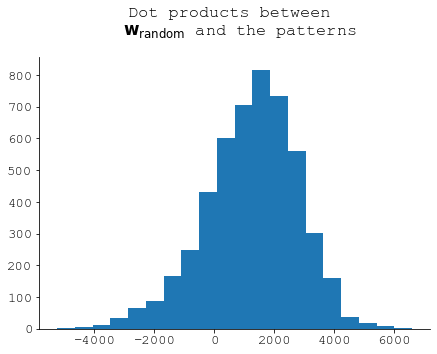

In [15]:
# generate random weights
w_random = np.random.randn(d)

# predict labels
y_est = np.sign(X @ w_random)

correct = np.sum(y_est * y == 1)
print('%d out of %d patterns correctly classified (%5.2f%%)' % (correct, n, 100*correct/n))

fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(X @ w_random, bins=20)
_ = ax.set_title('Dot products between \n $\mathbf{w}_{\mathrm{random}}$ and the patterns\n')

OK, this is not great.

Let's visualize what's going on: pretend that the digits only have two pixels


 <div class="row">
  <div class="column">
    <center>
        <img src="figs/linear-random-1.svg" width="70%"/><br>
        some examples are missclassified
    </center>    
  </div>
  <div class="column">
    <center>
        <img src="figs/linear-random.svg" width="70%"/><br>
        we bump $\mathbf{w}$ "away" from the closest misclassified example    
    </center>   
  </div>
</div> 

We currently have for the "nearby" misclassified example $\mathbf{x}$ that

$$
\mathbf{w}^T \mathbf{x} = \alpha
$$

We want to compute a small bump in the direction of negative $\mathbf{x}$, say $c \mathbf{x}$ so that

$$
    (\mathbf{w} + c \mathbf{x})^T \mathbf{x} = 0
$$

Thus

$$
    \mathbf{w}^T \mathbf{x} + c \mathbf{x}^T \mathbf{x} = 0 
    \Longrightarrow
    c = - \frac{\mathbf{w}^T \mathbf{x}}{\mathbf{x}^T \mathbf{x}} = -\frac{\alpha}{\| \mathbf{x} \|^2}
$$


$$
    \mathbf{w}^T \mathbf{x} + c \mathbf{x}^T \mathbf{x} = 0 
    \Longrightarrow
    c = - \frac{\mathbf{w}^T \mathbf{x}}{\mathbf{x}^T \mathbf{x}} = -\frac{\alpha}{\| \mathbf{x} \|^2}
$$


In [17]:
# find indices of misclassfied examples
idx_miss = np.where(y != y_est)[0]

idx_miss
i = idx_miss[np.argmin(np.abs((X @ w_random)[idx_miss]))]
print('The smallest dot product (in abs) is %.2e' % \
      (np.dot(X[i], w_random)))

w_random_bumped = w_random - 1.000001 * X[i] * np.dot(X[i], w_random) \
                / np.linalg.norm(X[i])**2

print('The smallest dot product after updating the weights is %.2e' % \
      (np.dot(X[i], w_random_bumped)))


The smallest dot product (in abs) is 1.01e-02
The smallest dot product after updating the weights is -1.01e-08


In [18]:
y_est_bumped = np.sign(X @ w_random_bumped)
correct_bumped = np.sum(y_est_bumped * y == 1)
print('Correct before: %d/%d, correct after: %d/%d' % (correct, n, correct_bumped, n))

Correct before: 2393/5000, correct after: 2394/5000


# Let's make this into an algorithm

- Cycle over "training examples" and do a small update for each
- Repeat some number of times



In [16]:
# write a function that implements this recipe
# nb: we'll write a nice one later

def train(X, y, lr=0.1, n_iter=30):
    # X : a (n, d) matrix with rows being training examples (digits)
    # y : a (d, 1) vector of labels

    n, d = X.shape
    w = np.zeros((d,))
    
    for i_iter in range(n_iter):
        for i_example in range(n):
            y_est = np.sign(np.dot(X[i_example], w))

            if y_est != y[i_example]:
                w += lr * X[i_example] * y[i_example]
        
    return w

28 out of 5000 patterns are misclassified


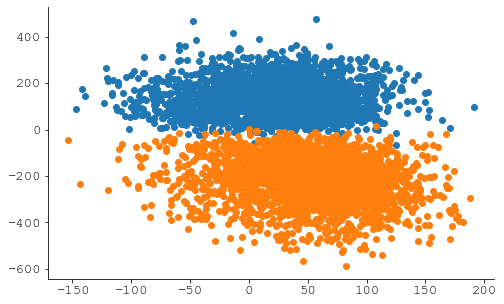

In [20]:
w = train(X, y)

error_count = np.sum(np.sign(X @ w) * y < 0 )
print("%d out of %d patterns are misclassified" % (error_count, n))
 
w_orth = np.random.randn(d) 
w_orth -= w * np.dot(w_orth, w) / np.linalg.norm(w)**2

X_w = X @ w / np.linalg.norm(w)
X_orth = X @ w_orth / np.linalg.norm(w_orth)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_orth[y==1], X_w[y==1])
_ = ax.scatter(X_orth[y==-1], X_w[y==-1])

# What do the weights do?

We can visualize the weights as a 28 $\times$ 28 image and see exactly how the different digits are distinguished. Very _interpretable_!

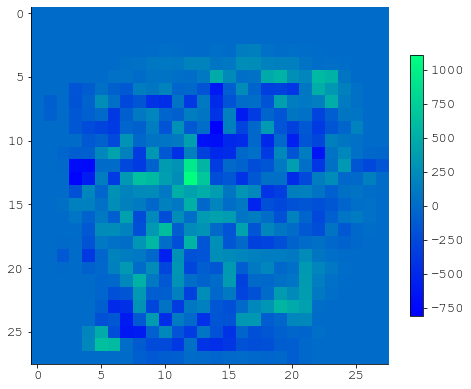

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(w.reshape(28, 28), cmap='winter')
_ = fig.colorbar(im, ax=ax, shrink=0.6)

# This seems to be reasonable

Are there other reasonable ideas to classify digits?



<center>
<img src="figs/Meyer_Lemon.jpg" width="30%"  style="vertical-align:middle;margin:2% 2%" />
</center>
Imagine I ask you to classify a citrus as either a Meyer lemon or an ordinary lemon. I also give you 30 ordinary lemons and 30 Meyer lemons.


We can compare the fruit under scrutiny to both piles of citri...

In [25]:
k = 31
error_count = 0
for i_example in tqdm(range(n), desc='n processed'):

    # compute distance from the current example to all other examples
    dist2 = np.sum((X - X[i_example])**2, axis=1)

    # find k closest examples, ignoring zero distance to the current one
    k_closest_idx = np.argsort(dist2)[1:k + 1]

    # do majority vote on the corresponding labels
    y_est = np.sign(y[k_closest_idx].sum())

    # check for errors
    if y_est * y[i_example] < 0:
        error_count += 1

print("The number of misclassified points is: ", error_count)

n processed: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.32it/s]

The number of misclassified points is:  43


# Which $k$ works best? (+ the power of vectorization)


100%|█████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1331.96it/s]


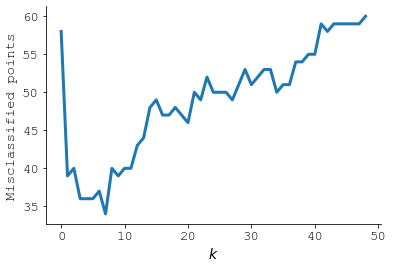

In [26]:
ec = []
G = X @ X.T # ref: EDMs -> hw
dist22 = np.diag(G)[:, np.newaxis] - 2*G + np.diag(G)[np.newaxis, :]
sorted_dist_idx = np.argsort(dist22, axis=1)

for k in tqdm(range(2, 100, 2)):
    k_closest_idx = sorted_dist_idx[:, 1:k + 1]
    y_est = np.sign(y[k_closest_idx].sum(axis=1))
    error_count = (y_est * y <= 0).sum()    
    ec.append(error_count)

_ = plt.plot(ec, linewidth=3)
plt.xlabel('$k$')
_ = plt.ylabel('Misclassified points')

It seems that both $k$ too small and $k$ too large are bad

Can we visualize what is going on? We need to use a low-dimensional example

# The Iris flower datset

- Yet another legendary dataset used by every data science course on the planet
- Ronald Fisher, probably the most important statistician of all time (and a complicated person)

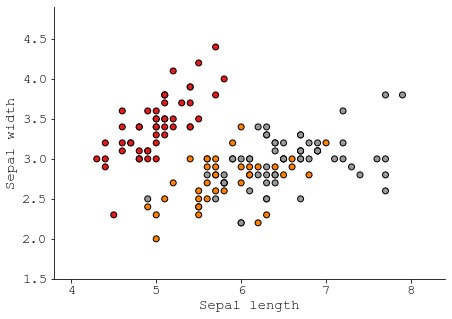

In [27]:
# Modified from Gaël Varoquaux

from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris.data[:, :2]  # take only the first two features
y_iris = iris.target

x_min, x_max = X_iris[:, 0].min() - 0.5, X_iris[:, 0].max() + 0.5
y_min, y_max = X_iris[:, 1].min() - 0.5, X_iris[:, 1].max() + 0.5

plt.figure(figsize=(7, 5))

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
_ = plt.ylim(y_min, y_max)

We again focus on two classes

In [28]:
excluded_class = 2
classes = np.setdiff1d([0, 1, 2], excluded_class)
X = X_iris[y_iris != excluded_class]
y = y_iris[y_iris != excluded_class]
y[y == classes[0]] = -1
y[y == classes[1]] = 1

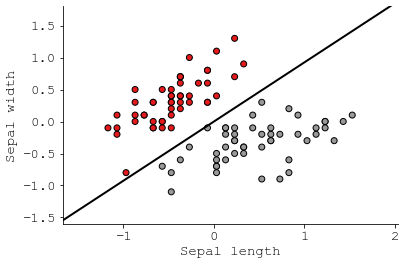

In [29]:
X -= X.mean(axis=0)

w = train(X, y)
w /= np.linalg.norm(w)
w_orth = np.array([1, -w[0] / w[1]])

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
s = 20
plt.plot([-s*w_orth[0], s*w_orth[0]], [-s*w_orth[1], s*w_orth[1]], 'k', linewidth=2)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.xlim(x_min, x_max)
_ = plt.ylim(y_min, y_max)

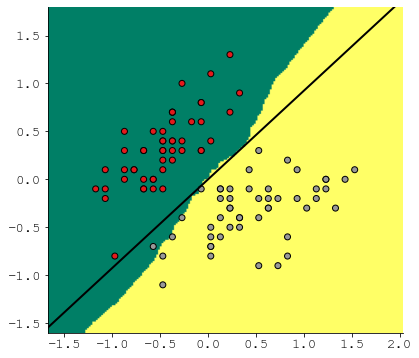

In [32]:
k = 51
n_points = 200
x_ = np.linspace(x_min, x_max, n_points)
y_ = np.linspace(y_min, y_max, n_points)

xx, yy = np.meshgrid(x_, y_)
label = np.zeros(xx.shape)

for i in range(n_points):
    for j in range(n_points):
        point = np.array([xx[i, j], yy[i, j]]) # classify current point
        knn_idx = np.argsort(np.sum((X - point)**2, axis=1))[:k]
        label[i, j] = np.sign(y[knn_idx].sum())

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=(y/2+1), cmap=plt.cm.Set1, edgecolor="k")
plt.plot([-s*w_orth[0], s*w_orth[0]], [-s*w_orth[1], s*w_orth[1]], 'k', linewidth=2)
_ = plt.imshow(np.flipud(label), cmap='summer', extent=[x_min, x_max, y_min, y_max])

# How cool are we?

# Well, we first reinvented the _perceptron_

 <div class="row">
  <div class="column">
    <center>
        <img src="figs/rosenblatt.jpg" width="50%"/> 
    </center>    
  </div>
  <div class="column">
    •  A brainchild of Frank Rosenblatt <br>
    •  Huge press coverage at the time <br> 
    •  Huge implications today <br><br>

    The New York Times, 1958

<img src="figs/nytp.png" width="60%"/>
  </div>
</div> 


<center>
<img src="figs/0925_rosenblatt4.jpg" width="80%"/>
</center>

# We then reinvented $k$ nearest neighbors

 <div class="row">
  <div class="column">
    <center>
<img src="figs/tomcover.jpg" width="40%"/>
    </center>    
  </div>
  <div class="column"><br>
    • Evelyn Fix & Joseph Lawson Hodges Jr. circa 1951 <br><br>
    • Expanded and analyzed by Thomas Cover (on the left)  <br><br>
    • Despite simplicity it is an incredibly useful technique, and one which has been keeping machine learning theorists busy for many years <br>
  </div>
</div> 


# Some of the questions we must answer

- Which classifier is better?
- What does "better" even mean?

## We have been committing a crime

- We "trained", "validated", and "tested" on one and the same dataset
- For $k$NN it's even a bit silly (consider the iris example)

# This course

- "Pattern recognition" very close to "machine learning"
- Focus in PR is on "supervised learning"
    - classification
    - prediction
- But "unsupervised learning" plays a key role
    - representation learning
    - feature maps: learning good features

# Why pattern recognition or machine learning

The following couple of slides were made by __Volodymyr Kuleshov__ of Cornell Tech

# Machine Learning is all the rage

We hear a lot about machine learning (or ML for short) in the news.

<table><tr>
    <td><center><img src="img/breakthrough.jpg"/></center></td>
    <td><center><img width=90% src="img/alphago.jpeg"/></center></td>
    <td><center><img src="img/obama2.jpg"/></center></td>    
</tr></table>    

But what is it, really?

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# ML in Everyday Life: Search Engines

You use machine learning every day when you run a search engine query.

<center><img src="img/google.png"/></center>

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# ML in Everyday Life: Personal Assistants

Machine learning also powers the speech recognition, question answering and other intelligent capabilities of smartphone assistants like Apple Siri.
<table><tr>
    <td><center><img src="img/siri.png"/></center></td>
    <td><center><img src="img/google_assistant.png"/></center></td>
</tr></table>  

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# ML in Everyday Life: Spam/Fraud Detection

Machine learning is used in every spam filter, such as in Gmail.
<br>
<center><img src="img/spam.png"/></center>

ML systems are also used by credit card companies and banks to automatically detect fraudulent behavior.

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# ML in Everyday Life: Self-Driving Cars

One of the most exciting and cutting-edge uses of machine learning algorithms are in autonomous vehicles.

<center><img width="80%" src="img/waymo.jpg"/></center>

# A Definition of Machine Learning

In 1959, Arthur Samuel defined machine learning as follows.

> Machine learning is a field of study that gives computers the ability to learn without being explicitly programmed.

What does "learn" and "explicitly programmed" mean here? Let's look at an example.

# An Example: Self Driving Cars

A self-driving car system uses dozens of components that include detection of cars, pedestrians, and other objects.
<br>
<center><img width=80% src="img/tesla.jpg"/></center>

<font size="2">Slide by __Volodymyr Kuleshov__</font>


# Self Driving Cars: A Rule-Based Algorithm

One way to build a detection system is to write down rules.
<left><img width=50% src="img/tesla_zoom.jpg"/></left>

<!-- <table style="border: 1px"><tr>
    <td><left>One way to build a detection system is to write down rules.</left></td>
    <td><img src="img/tesla_zoom.jpg"/></td>
</tr></table> -->

In [ ]:
# pseudocode example for a rule-based classification system
object = camera.get_object()
if object.has_wheels(): # does the object have wheels?
    if len(object.wheels) == 4: return "Car" # four wheels => car    
    elif len(object.wheels) == 2:
        if object.seen_from_back():
            return "Car" # viewed from back, car has 2 wheels
        else:
            return "Bicycle" # normally, 2 wheels => bicycle
return "Unknown" # no wheels? we don't know what it is

In practice, it's almost impossible for a human to specify all the edge cases.

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# Self Driving Cars: An ML Approach

The machine learning approach is to teach a computer how to do detection by showing it many examples of different objects.

<center><img src="img/tesla_data.png"/></center>

No manual programming is needed: the computer learns what defines a pedestrian or a car on its own!

<font size="2">Slide by __Volodymyr Kuleshov__</font>


# Revisiting Our Definition of ML

> Machine learning is a field of study that gives computers the ability to learn without being explicitly programmed. (Arthur Samuel, 1959.)

This principle can be applied to countless domains:
medical diagnosis, factory automation, machine translation, and many more!


<font size="2">Slide by __Volodymyr Kuleshov__</font>

# Why Machine Learning?

Why is this approach to building software interesting?



* It allows building practical systems for real-world applications that couldn't be solved otherwise.



* Learning is wildly regarded as a key approach towards building general-purpose artificial intelligence systems.

* The science and engineering of machine learning offers insights into human intelligence.

<font size="2">Slide by __Volodymyr Kuleshov__</font>

# History



# Beware

- The language of pattern recognition is mathematical
- We will give intuition but to really get it, make sure you know your probability and linear algebra well
- That is a good thing; without the formal understanding PR would not be where it's now
- Let me tell you a story about interviewing people for CeDA...

# Key mathematical tools

## Probability theory (and statistics)

- What is a random variable? A random vector?
- A joint distribution? A conditional distribution? An expectation?
- What are independent random variables?
- ...

## Linear algebra

- What does $\mathbf{w}^T \mathbf{x}$ mean? How about $\| \mathbf{x} \|$?
- Why is $\arg \min_{\mathbf{w}} ~ \| \mathbf{y} - \mathbf{X} \mathbf{w} \|^2 + \lambda \| \mathbf{x} \|^2 $ precisely $\mathbf{x}^* = ( \mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^T \mathbf{y}$
- What does it mean to invert a matrix?
- What is a projection?
- ...

# The course team

# Course structure, week structure, grade structure

### Lectures
- Tuesdays (8:40 - 10:00?)
- Fridays (10:15 - 12:00)

### Recitations 

- Wednesdays (14:15 - 16:00)
- Clinique and office hours on Mondays; sometimes we may do an interesting proof (kNN or perceptron or ...)

### Known perturbations

- There will be regular perturbations to this plan
- Next week I will teach on Monday and either post a video or find a replacement for Friday

# Online resources


### Course website

- [https://sada.dmi.unibas.ch/teaching/pr22](https://sada.dmi.unibas.ch/teaching/pr22)

### Gradescope

- Assignment submission will happen through Gradescope
- Details to follow in a jiffy

### Forum

- We'll use piazza
- Details to follow in jiffy


# Grading scheme

| What | Frequency | How much? 
|------|-----------|-----------
| Graded homework assignments | about biweekly | 50% 
| Final written exam | a one-off | 40%
| Attendance and participation | weekly | 10% 

- To write the final exam you need to make at least 50% HW points in total with a reasonable attempt at every assignment
- Attendance will be taken at random points throughout the semester
- Scheme subject to minor tweaks in the first few weeks


# The bad news and the good news

### Bad

It won't be easy. 🥹

### Good

It will be professionally and academically rewarding. 💪🏼

# A rough plan (this will certainly evolve)

| week | theme(s) |
| ---- | -------- |
| 1    |    Introduction to PR      |
| 2    |    Modeling knowledge, probabilistically      |
| 3    |    Supervised learning   |
| 4    |    Linear methods and the importance of good features     |
| 5    |        Signal processing, good features for images, sounds, text, ...  |
| 6    |     Signal processing, the multiscale idea, seeds of CNNs     |
| 7    |       Deblurring and denoising: linear methods   |
| 8    |        Statistical framing for deblurring and denoising, image models  |
| 9   |      Deep learning    |
| 10   |      Deep learning    |
| 11   |      Sampling (MCMC, ...)    |
| 12   |      Sampling (MCMC, ...    |
| 13   |      Applications of MCMC to the stuff above   |
| 14 | TBD | 


# Quiz

- How would our perceptron behave if the learning rate is multiplied by 10? Recall that we initialized the weights to an all-zero vector
- When is it a good idea to use a small k in k-nearest-neighbor classification?

# Summary -> Next time

- Cautionary tales: not everything is pink in PR land
- Generalization and clever Hans predictors (der Kluge Hans)
- What is a pattern? (spoiler: it's a vector)
- What is a "feature"?
- Towards modeling knowledge, the probabilistic way


<center>
<br>
<img src="figs/CleverHans.jpg" width="35%"/>
</center>


In [6]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Courier New', 'monospace']

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Text(0.5, 1.0, 'Some title with $\\int_{\\mathbb{R}} e^{i\\omega t} dt$')

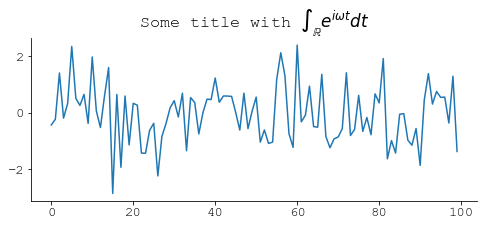

In [7]:
import matplotlib as mpl

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(8, 3))
plt.plot(np.random.randn(100))
plt.title('Some title with $\int_{\mathbb{R}} e^{i\omega t} dt$')
